In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
def diff(x,y):
    if x>y:
        return (x-y)
    else:
        return(y-x)

In [4]:
data = pd.read_csv("Master_withDR3.csv")
filter = data['PARALLAX'] > 0
filtered = data[filter]
print(len(data) - len(filtered))

3577


<AxesSubplot:xlabel='RA', ylabel='DEC'>

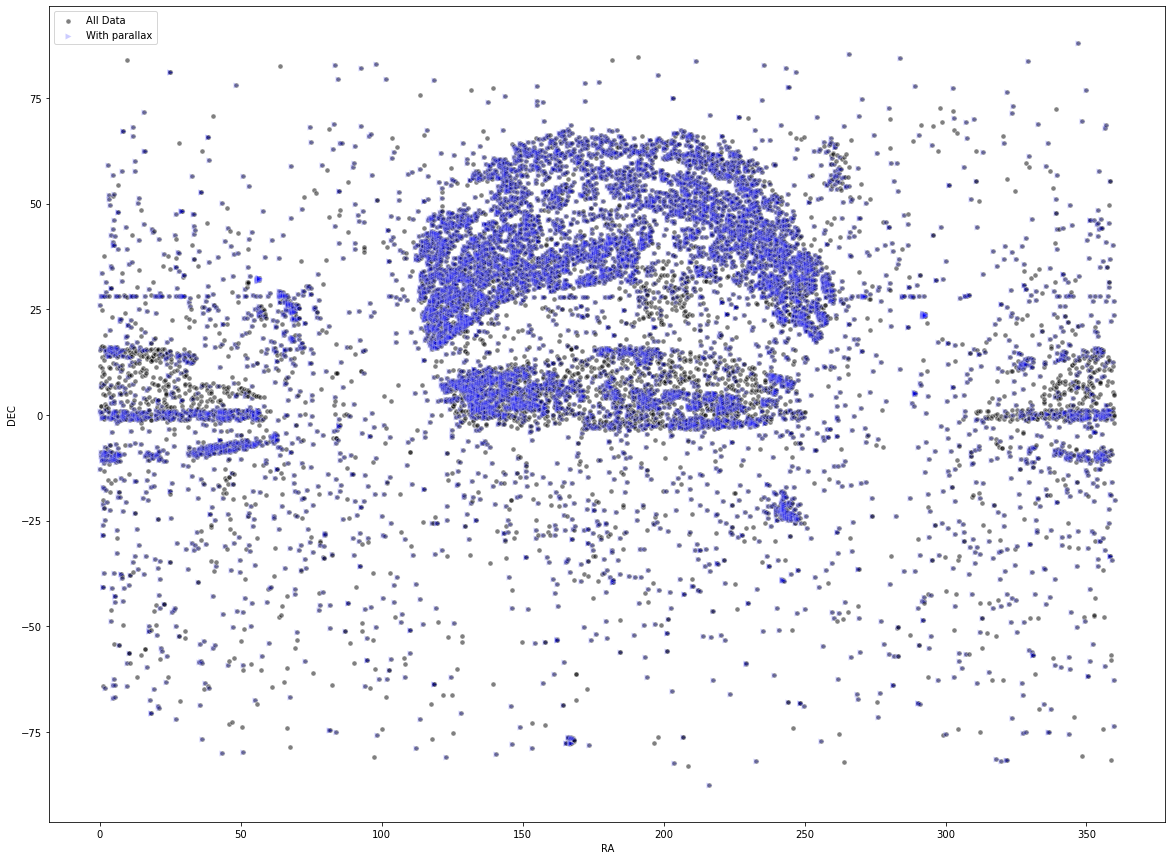

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
sns.scatterplot(x= 'RA', y ='DEC', data = data, marker = '.', s = 100, color = 'black', alpha = 0.5, label = 'All Data')
sns.scatterplot(x= 'RA', y = 'DEC', data = filtered, marker = '>', color = 'blue', alpha = 0.2 , label = 'With parallax')

In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Column

In [6]:
data1 = filtered
data2 = filtered

match=[]
number=[]
candid=[]
candidstr=[]

for i in range(len(data1)):
    ra = data1.iloc[i]['RA']
    dec = data1.iloc[i]['DEC']
    radius = 1.
    filter = data2['RA'] > (ra - radius/np.cos(dec*np.pi/180))  
    filter &= data2['RA'] < (ra + radius/np.cos(dec*np.pi/180))
    filter &= data2['DEC'] > (dec - radius)            
    filter &= data2['DEC'] < (dec + radius)            
    data3 = data2[filter]         
    
    
    c1 = SkyCoord(ra = data1.iloc[i]['RA']*u.deg, 
                dec = data1.iloc[i]['DEC']*u.deg)
    
    match2=[]  
    if (data1.iloc[i]['SHORTNAME']) in candid:
        continue
    for j in range(len(data3)):
        c2= SkyCoord(ra=data3.iloc[j]['RA']*u.deg, 
                     dec= data3.iloc[j]['DEC']*u.deg)
        dist=c1.separation(c2)
        distarcsec= dist.arcsecond
        
        if (data1.iloc[i]['SHORTNAME'] == data3.iloc[j]['SHORTNAME']):
            continue
        
        if distarcsec < (100.*data1.iloc[i]['PARALLAX']):
            
            w1= data1.iloc[i]['PARALLAX']
            sigGUCD= data1.iloc[i]['PARALLAXERR']
            w2 = data3.iloc[j]['PARALLAX']
            
            if  diff(w1,w2) < max(1, 3*sigGUCD):
                
                mura1 = data1.iloc[i]['PMRA']
                mudec1 = data1.iloc[i]['PMDEC']
                musq1 = mudec1**2 + mura1**2
                mutot1 = np.sqrt(musq1)
                
                mura2 = data3.iloc[j]['PMRA']
                mudec2 = data3.iloc[j]['PMDEC']
                musq2 = mudec2**2 + mura2**2
                mutot2 = np.sqrt(musq2)
                
                if diff(mutot1,mutot2) < 0.1*mutot1:
                    pos_ang1_rad =  np.arctan(
                        data1.iloc[i]['PMRA']/data1.iloc[i]['PMDEC'])
                    pos_ang1 = np.degrees(pos_ang1_rad)
                    
                    if pos_ang1 < 0:
                        pos_ang1 = pos_ang1 + 360
                    
                    pos_ang2_rad = np.arctan(data3.iloc[j]['PMRA']/data3.iloc[j]['PMDEC'])
                    pos_ang2 = np.degrees(pos_ang2_rad) 
                    
                    if pos_ang2 < 0:
                        pos_ang2 = pos_ang2 +360
                    
                    if diff(pos_ang1,pos_ang2) < 15:
                        match2.append(data3.iloc[j]['SHORTNAME'])
                        candid.append(data3.iloc[j]['SHORTNAME'])
    
    if len(match2) > 0:
        match.append(data1.iloc[i,:].values)
        canlist = ', '.join(map(str, match2))
        candidstr.append(canlist)
        number.append(len(match2))

In [8]:
column_names = data.columns

matched_data = pd.DataFrame(match, columns = column_names)
matched_data.insert(15, "COMPANIONS", candidstr, True)
matched_data.insert(16, "NUMCOMPANION", number, True)

secondary = []
for i in range(len(data1)):
    if data1.iloc[i]['SHORTNAME'] in set(candid):
        secondary.append(data1.iloc[i,:].values)
secondary = pd.DataFrame(secondary, columns = column_names)

In [9]:
print(f"Matched data row: {len(matched_data)}\n\
Secondary data rows: {len(secondary)}")
matched_data.to_csv("matched_dr3.csv", sep = ",")
secondary.to_csv("secondary_dr3.csv", sep = ",")

Matched data row: 234
Secondary data rows: 249


In [10]:
def Converttolist(string): 
    string_list = list(string.split(",")) 
    string_list = [a.strip() for a in string_list ]
    return string_list

def remove_duplicate(x):
    return list(dict.fromkeys(x))

In [11]:
primary_companions = {}
for i in range(len(matched_data)):
    obj1 = matched_data.iloc[i]['SHORTNAME']
    obj2 = Converttolist(matched_data.iloc[i]['COMPANIONS'])
    obj2.append(obj1)   #merging matched objects together
    all_obj = remove_duplicate(obj2) 
    
    ra = matched_data.iloc[i]['RA'] #Right Ascension 
    dec = matched_data.iloc[i]['DEC'] # Declination
    radius= 1. 
    filter = data['RA']> (ra - radius/np.cos(dec*np.pi/180))
    filter &= data['RA'] < (ra + radius/np.cos(dec*np.pi/180))
    filter &= data['DEC'] > (dec - radius)
    filter &= data['DEC'] < (dec + radius)
    data_filtered = data[filter]
    obj_dict={}
    for j in range(len(data_filtered)):
        if data_filtered.iloc[j]['SHORTNAME'].strip() in all_obj:
            obj_dict[data_filtered.iloc[j]['SHORTNAME'].strip()] = (
                data_filtered.iloc[j]['GAIAG'] + 
                5*np.log10(data_filtered.iloc[j]['PARALLAX']/100.))
    brightest_obj = min(obj_dict.items(), key = lambda x : x[1])
    obj2.remove(brightest_obj[0])
    primary_companions[brightest_obj[0]] = obj2
            
dict_new={}
key_rm=[]
for i in primary_companions:
    for j in primary_companions:
        if i==j:
            continue
        if primary_companions[i] == primary_companions[j]:
            dict_new[
                '\n'.join(map(
                    str, primary_companions[i]))] = [i,j]
            key_rm.append(i)
            key_rm.append(j)
            
keys_to_remove = set(key_rm).intersection(
    set(primary_companions.keys()))
for key in keys_to_remove:
    del primary_companions[key]
primary_companions.update(dict_new) 

primary_final=[]
secondary_final=[]

for keys,values in primary_companions.items():
    primary_final.append(keys)
    for value in values:
        secondary_final.append(value)

primary_table=[]
for i in range(len(data)):
    if data.iloc[i]['SHORTNAME'].strip() in primary_final:
        primary_table.append(data.iloc[i,:].values)

primary_table = pd.DataFrame(primary_table, columns = column_names)

In [12]:
len(primary_table)

228

In [13]:
companions_table=[]
companion_number=[]

for i in range(len(primary_table)):
    for j in primary_companions:
        if primary_table.iloc[i]['SHORTNAME'].strip() == j:
            companion_number.append(
                len(primary_companions[j]))
            
            companions_table.append(
                '; '.join(map(
                    str,primary_companions[j])))

In [14]:
primary_table.insert(15, "COMPANIONS", companions_table, True)
primary_table.insert(16, "NUMCOMPANION", companion_number, True)

In [15]:
secondary_final = remove_duplicate(secondary_final)
secondary_table=[] 
for i in range(len(data)):
    if data.iloc[i]['SHORTNAME'].strip() in secondary_final:
        secondary_table.append(data.iloc[i,:].values)
        
secondary_table = pd.DataFrame(secondary_table, columns = column_names)

In [16]:
primary_table.to_csv("Primary_matches.csv", sep =",")
secondary_table.to_csv("secondary_matches.csv", sep = ",")

# Plotting binaries on HR diagram

 After comparing binaries found using criteria provided in (cite paper Prof.Smart) with the binaries in basic info with search radius 20 arcsec. 31 primary systems fount not to be in baisc info.  Connect the secondary to the binaries on HR diagram. 

In [1]:
import pandas as pd 

data = pd.read_csv("Master_withDR3.csv")

In [2]:
print(list(data.columns))

['SHORTNAME', 'DISCOVERYNAME', 'DISCOVERYREFNAME', 'RA', 'DEC', 'POSITIONREFNAME', 'POSITIONEPOCH', 'PECULIARNAME', 'PECULIARREFNAME', 'MGCANDIDACYNAME', 'MGCANDIDACYREFNAME', 'MULTIPLEFLAGNAME', 'MULTIPLEFLAGREFNAME', 'COMMENTSNAME', 'SPTOPTNAME', 'SPTOPTREFNAME', 'SPTNIRNAME', 'SPTNIRREFNAME', 'SPTPHONAME', 'SPTPHOREFNAME', 'SPTNUM', 'PARALLAX', 'PARALLAXERR', 'PARALLAXREFNAME', 'PMRA', 'PMRAERR', 'PMDEC', 'PMDECERR', 'PMREFNAME', 'RV', 'RVERR', 'RVREFNAME', 'TMASSJ', 'TMASSJERR', 'TMASSH', 'TMASSHERR', 'TMASSK', 'TMASSKERR', 'TMASSFLAGNAME', 'WISEW1', 'WISEW1ERR', 'WISEW2', 'WISEW2ERR', 'WISEW3', 'WISEW3ERR', 'WISEFLAGNAME', 'PS1G', 'PS1GERR', 'PS1R', 'PS1RERR', 'PS1I', 'PS1IERR', 'PS1Z', 'PS1ZERR', 'PS1Y', 'PS1YERR', 'PS1FLAGNAME', 'PS1REFNAME', 'SDSSG', 'SDSSGERR', 'SDSSR', 'SDSSRERR', 'SDSSI', 'SDSSIERR', 'SDSSZ', 'SDSSZERR', 'SDSSFLAGNAME', 'SDSSREFNAME', 'IRACCH1', 'IRACCH1ERR', 'IRACCH2', 'IRACCH2ERR', 'MKOY', 'MKOYERR', 'MKOJ', 'MKOJERR', 'MKOH', 'MKOHERR', 'MKOK', 'MKOKERR',

In [4]:
pd.set_option("display.max_columns", None)
print(data.head(5))

    SHORTNAME            DISCOVERYNAME     DISCOVERYREFNAME        RA  \
0  J0000+1523  ULASJ000005.87+152354.4  2016A&A...589A..49S  0.024492   
1  J0000+1136  ULASJ000010.43+113602.2  2015MNRAS.450.2486C  0.043463   
2  J0000+2554    2MASS00001354+2554180  2004AJ....127.3553K  0.056354   
3  J0000+0051                      ...  2008AJ....135..785W  0.091531   
4  J0000-1245     2MASSJ0000286-124515  2007AJ....133..439C  0.118741   

         DEC      POSITIONREFNAME  POSITIONEPOCH PECULIARNAME  \
0  15.398469  2007MNRAS.379.1599L        2007.82          ...   
1  11.600600  2007MNRAS.379.1599L        2010.57          ...   
2  25.905569  2006AJ....131.1163S        2016.00          ...   
3   0.858103                 GDR3        2016.00          ...   
4 -12.754698                 GDR3        2016.00          ...   

       PECULIARREFNAME MGCANDIDACYNAME   MGCANDIDACYREFNAME MULTIPLEFLAGNAME  \
0  ...................             ...        CHI:2.2200000              ...   
1  .......